# Vision Transformer

In [1]:
import sys
sys.dont_write_bytecode = True

import os
import tensorflow as tf

from evaluate.F1ScoreMetric import F1ScoreMetric as f1
from module.DatasetProcessor import DatasetProcessor
from script.plot_training_history import plot_training_history

In [2]:
# Display version of TensorFlow and Python
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Tue Sep 19 16:21:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0              20W /  80W |    255MiB /  6144MiB |      8%      Default |
|                                         |     

## Configuration

In [3]:
CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUST VS MANGA", 
    "image_size": 224,
    "patch_size": 32, # Increase patch size from 16 -> 32 for faster computation
    "num_head": 12,
    "latent_size": 768,
    "mlp_size": 3072,
    "trans_layer": 6,

    "batch": 32, # Batch size
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4), # main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-4), # fine-tuning
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

## Initializing

In [4]:
if CFG["fp16"]:
    print("Activating mixed precision float16 ... ")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Declare functions

In [5]:
def Custom_ImageDataGenerator(image_path, label, image_size):
    # Read the image file from the given path
    image = tf.io.read_file(image_path)
    
    # Decode the image into a tensor, disabling animation expansion
    image = tf.image.decode_image(image, expand_animations=False)
    
    # Resize the image to the specified dimensions while preserving aspect ratio and using antialiasing
    image = tf.image.resize(image, (image_size, image_size),
                            preserve_aspect_ratio=True,
                            antialias=True)
    
    # Resize the image with padding to ensure it has the exact dimensions specified
    image = tf.image.resize_with_pad(image, image_size, image_size)
    
    # Normalize the image pixel values to the range [0, 1] by dividing by 255.0
    image = image / 255.0
    
    return image, label

In [6]:
def raw_data_processing(data_list, dict_class, image_size):
    # Extract the image file paths from the data_list
    path_list = [path for path, _ in data_list]
    
    # Map class labels to their corresponding dictionary values
    label_list = [dict_class[label] for _, label in data_list]
    
    # Create a list of image size values to be used as a constant size in the dataset
    size_list = [image_size] * len(label_list)
    
    # Create a TensorFlow dataset from the extracted lists
    dataset = tf.data.Dataset.from_tensor_slices((path_list, label_list, size_list))
    
    return dataset

## Dataset preparation

In [7]:
# Create a list of tuples, where each tuple contains the image path and its class label
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [(path, path.split('\\')[-2]) for path in path_list]

In [8]:
# Call custom class module
processor = DatasetProcessor(path_list)

# Prepare class list and its corresponding dictionary for class-label mapping
processor.create_class_dict(mode="onehot")

processor.class_list, processor.class_dict

(['ILLUSTRATION', 'MANGA'],
 {'ILLUSTRATION': array([1., 0.], dtype=float32),
  'MANGA': array([0., 1.], dtype=float32)})

In [9]:
# Split the dataset into training and testing datasets
processor.train_test_splitter(test_ratio=10)

len(processor.train_data), len(processor.test_data)

1873 train data including
ILLUSTRATION: 1076
MANGA: 797
209 test data including
ILLUSTRATION: 120
MANGA: 89
ILLUSTRATION class has weight: 0.8704
MANGA class has weight: 1.1750


(1873, 209)

In [10]:
# Prepare the training dataset
train_dataset = raw_data_processing(processor.train_data, processor.class_dict, CFG["image_size"])
train_dataset = train_dataset.map(Custom_ImageDataGenerator)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=CFG["batch"], drop_remainder = True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare the testing dataset
test_dataset = raw_data_processing(processor.test_data, processor.class_dict, CFG["image_size"])
test_dataset = test_dataset.map(Custom_ImageDataGenerator)
test_dataset = test_dataset.batch(batch_size=CFG["batch"], drop_remainder = False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## Model Creation

I use the traditional model ViT Base for this study, but I have increased the image patch size from 16 to 32.

In [11]:
"""
# They are same
from model.VisionTransformer import VisionTransformer as CustomViT
model = CustomViT(
    image_size=CFG["image_size"],
    patch_size=CFG["patch_size"],
    num_classes=len(processor.class_list),
    num_head=CFG["num_head"],
    latent_size=CFG["latent_size"],
    num_layer=CFG["trans_layer"],
    mlp_size=CFG["mlp_size"]
)
"""

from model.VisionTransformer import ViTBase

model = ViTBase(
    image_size=CFG["image_size"],
    patch_size=CFG["patch_size"],
    num_classes=len(processor.class_list),
)

model.summary()

Model: "ViT_I224x224_P32_L12_H12_D768_MLP3072_2Class"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_image (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Image_Patcher (ImagePatcher) (None, 49, 3072)          0         
_________________________________________________________________
Patch_Encoder (PatchEncoder) (None, 49, 768)           2397696   
_________________________________________________________________
ClassToken (ClassToken)      (None, 50, 768)           768       
_________________________________________________________________
Transformer_Encoder_1 (Trans (None, 50, 768)           7087872   
_________________________________________________________________
Transformer_Encoder_2 (Trans (None, 50, 768)           7087872   
_________________________________________________________________
Transformer_Encoder_3 

### Training phase1: Main training

In [12]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=20, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss_func"], metrics=["accuracy", f1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
58/58 [==============================] - 40s 363ms/step - loss: 1.1947 - accuracy: 0.5296 - f1_score: 0.5296 - val_loss: 0.6574 - val_accuracy: 0.5933 - val_f1_score: 0.5933
Epoch 2/1000
58/58 [==============================] - 19s 328ms/step - loss: 0.7311 - accuracy: 0.5463 - f1_score: 0.5463 - val_loss: 0.7509 - val_accuracy: 0.5742 - val_f1_score: 0.5742
Epoch 3/1000
58/58 [==============================] - 19s 329ms/step - loss: 0.7496 - accuracy: 0.5264 - f1_score: 0.5264 - val_loss: 0.6501 - val_accuracy: 0.5789 - val_f1_score: 0.5789
Epoch 4/1000
58/58 [==============================] - 19s 331ms/step - loss: 0.6816 - accuracy: 0.5819 - f1_score: 0.5819 - val_loss: 0.6361 - val_accuracy: 0.6029 - val_f1_score: 0.6029
Epoch 5/1000
58/58 [==============================] - 19s 331ms/step - loss: 0.6534 - accuracy: 0.6088 - f1_score: 0.6088 - val_loss: 0.6297 - val_accuracy: 0.6507 - val_f1_score: 0.6507
Epoch 6/1000
58/58 [==============================] - 19s 332ms/s

### Training phase2: Fine-tuning

In [13]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.001, 
                                                     patience=10, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss_func"], metrics=["accuracy", f1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 27
Epoch 28/1000
58/58 [==============================] - 32s 378ms/step - loss: 0.6066 - accuracy: 0.6466 - f1_score: 0.6466 - val_loss: 0.6019 - val_accuracy: 0.6603 - val_f1_score: 0.6603
Epoch 29/1000
58/58 [==============================] - 20s 341ms/step - loss: 0.6051 - accuracy: 0.6557 - f1_score: 0.6557 - val_loss: 0.6017 - val_accuracy: 0.6364 - val_f1_score: 0.6364
Epoch 30/1000
58/58 [==============================] - 20s 340ms/step - loss: 0.6023 - accuracy: 0.6552 - f1_score: 0.6552 - val_loss: 0.6024 - val_accuracy: 0.6364 - val_f1_score: 0.6364
Epoch 31/1000
58/58 [==============================] - 20s 344ms/step - loss: 0.6023 - accuracy: 0.6579 - f1_score: 0.6579 - val_loss: 0.6054 - val_accuracy: 0.6268 - val_f1_score: 0.6268
Epoch 32/1000
58/58 [==============================] - 20s 346ms/step - loss: 0.6033 - accuracy: 0.6509 - f1_score: 0.6509 - val_loss: 0.6010 - val_accuracy: 0.6411 - val_f1_score: 0.6411
Epoch 33/1000
58/58 [=====

### Model evaluation by plotting history

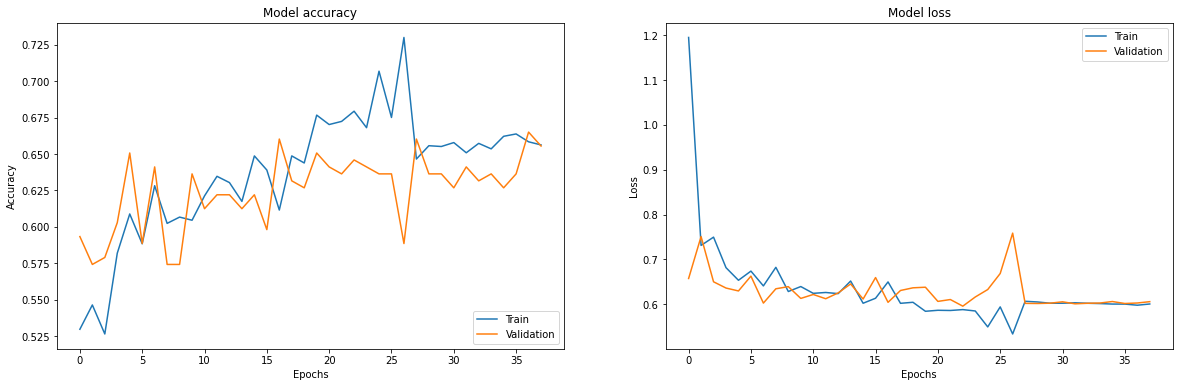

In [14]:
plot_training_history(model.history)

### Export model

In [15]:
model.save()